In [1]:
#Resolve the required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # To visualize
from tabulate import tabulate #To create pretty tables
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
from pprint import pprint

In [2]:

#read in the data
base_directory = "/home/jeanpierre/LibraMetrics/containersMetricsFiles/2020_08_20__04_37_53/"

files = ["merged/jp_mempool_process_incoming_transactions.csv", "merged/jp_consensus_process_proposal.csv", "merged/jp_consensus_process_new_round.csv"]

data_frames = []
for file_name in files:
    data_frame = pd.read_csv(base_directory + file_name, names=["txns", "duration"])
    data_frames.append(data_frame)

In [3]:
#Split the "jp_consensus_process_proposal.csv" into two parts,
#as the behaviour when #txns==0 and #txns>0 differs significantly
def split(arr, cond):
    return arr[cond], arr[~cond]

left, right = split(data_frames[1], data_frames[1]["txns"] == 0)
data_frames.append(right)
files.append("jp_consensus_process_proposal.csv WHERE #txns>0")

In [4]:
#convert duration from microseconds to milliseconds
i = 0
while i < len(data_frames):
    data_frames[i]["duration"] *= .001
    i += 1

left["duration"] *= 0.001

<ipython-input-4-6f1357628a3d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frames[i]["duration"] *= .001
<ipython-input-4-6f1357628a3d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left["duration"] *= 0.001


In [5]:
#Remove outliers that are >{std_from_mean}*std from the mean
std_from_mean = 3

mean_array = []
std_array = []
res_array = []

i = 0
while i < len(data_frames):
    data_frames[i] = data_frames[i][data_frames[i]['duration'].between(data_frames[i]['duration'].quantile(0), data_frames[i]['duration'].quantile(.999))]
    data_frames[i] = data_frames[i][data_frames[i]['txns'].between(data_frames[i]['txns'].quantile(0), data_frames[i]['txns'].quantile(.99))]

    mean = data_frames[i].groupby("txns").mean().reset_index()
    mean_array.append(mean)

    std = data_frames[i].groupby("txns").std().reset_index()
    std_array.append(std)
    
    std_mean = pd.merge(std, mean, on='txns', how='inner')
    std_mean.columns = ["txns", "std", "mean"]

    res = pd.merge(std_mean, data_frames[i], on='txns', how='inner')
    res = res[np.abs(res["duration"]-res["mean"]) <= (std_from_mean*res["std"])]
    res_array.append(res)
    print("Removed " + str(len(data_frames[i]) - len(res)) + " outliers out of " + str(len(data_frames[i])) + " entries")
    i += 1
    
print(left)
left = left[left['duration'].between(left['duration'].quantile(0), left['duration'].quantile(.99))]

Removed 2290 outliers out of 166165 entries
Removed 1559 outliers out of 80294 entries
Removed 444 outliers out of 20717 entries
Removed 309 outliers out of 22095 entries
       txns  duration
0         0    16.982
1         0    10.448
2         0    13.446
3         0     9.587
4         0     8.040
...     ...       ...
81161     0     5.129
81162     0     4.947
81163     0     4.885
81164     0     7.717
81165     0     7.964

[58864 rows x 2 columns]


10
42
42
50


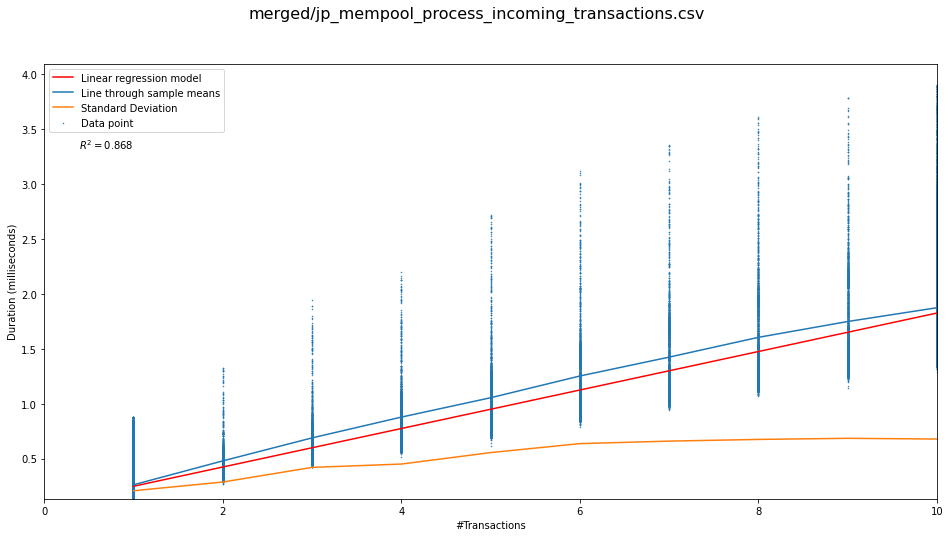

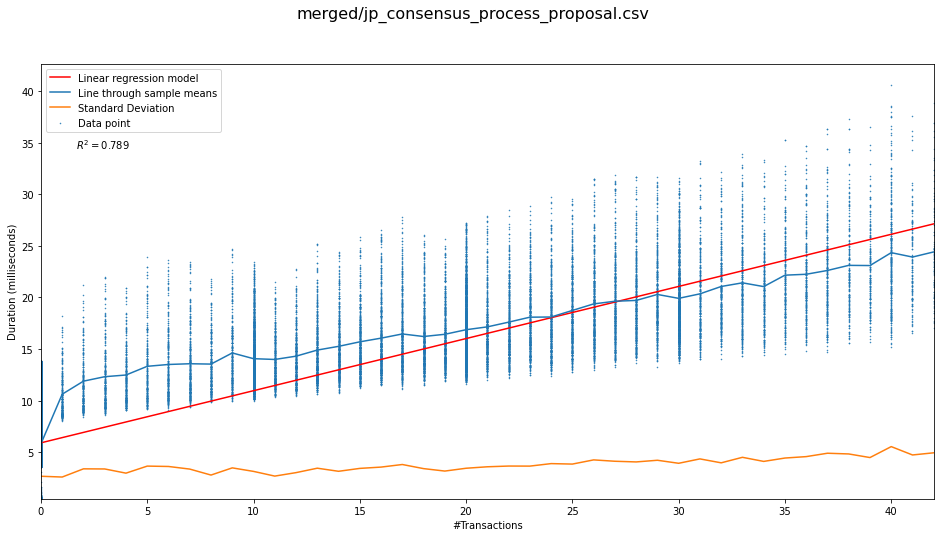

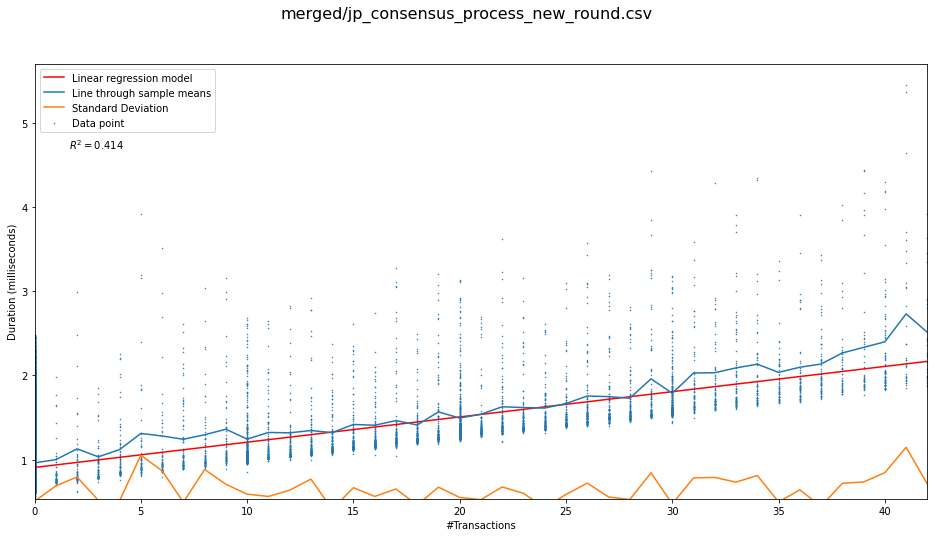

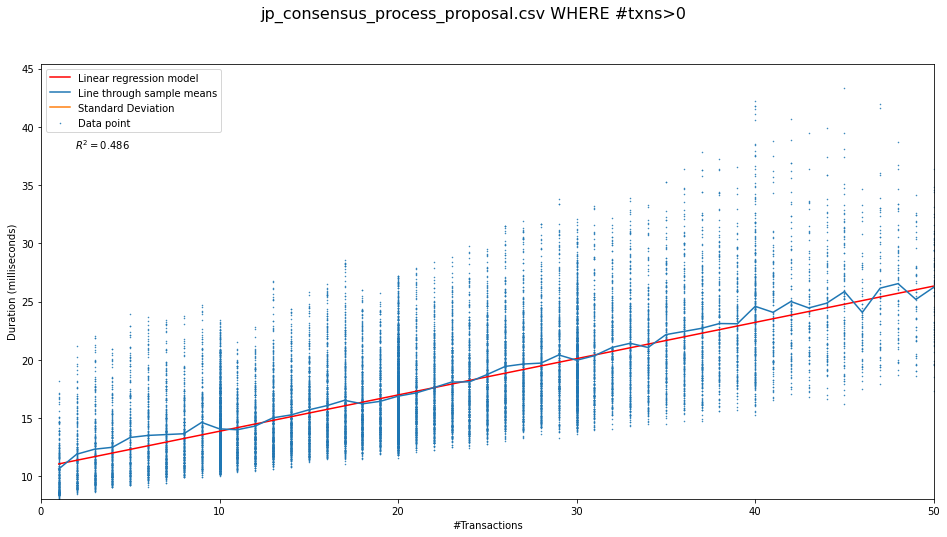

In [6]:
#Perform linear regression with R-sqaured score with pyplot
i = 0
while i < len(res_array):
    X = res_array[i].iloc[:, 0].values.reshape(-1, 1)
    Y = res_array[i].iloc[:, 3].values.reshape(-1, 1)
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    Y_pred = linear_regressor.predict(X)
    print(X.max())

    fig = plt.figure(figsize=(16,8))
    fig.suptitle(files[i], fontsize=16)
    ax = fig.add_subplot()
    ax.set_xlabel('#Transactions')
    ax.set_ylabel('Duration (milliseconds)')

    ax.scatter(X, Y, marker='.', s=1, label='Data point')
    ax.plot(X, Y_pred, color='red', label='Linear regression model')

    coefficient_of_dermination = r2_score(Y, Y_pred)

    #plt.errorbar(mean["txns"], mean["duration"], yerr=0, capsize=5, label="errorbar")
    ax.plot(mean_array[i]["txns"], mean_array[i]["duration"], label="Line through sample means")
    ax.plot(std_array[i]["txns"], std_array[i]["duration"], label="Standard Deviation")

    ax.text(0.1, 0.8, "$R^2={0:.3f}$".format(coefficient_of_dermination), verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes)
    plt.legend(loc='upper left')
    ax.set_xlim(0, X.max())
    ax.set_ylim(Y.min())
    #plt.savefig('pic.png')
    i += 1

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


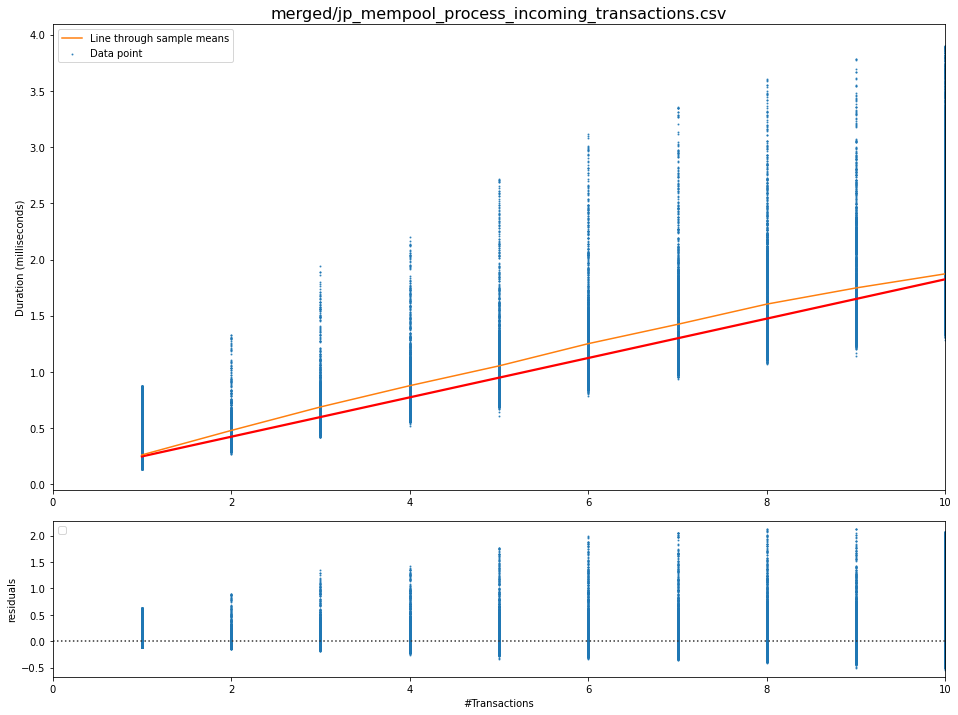

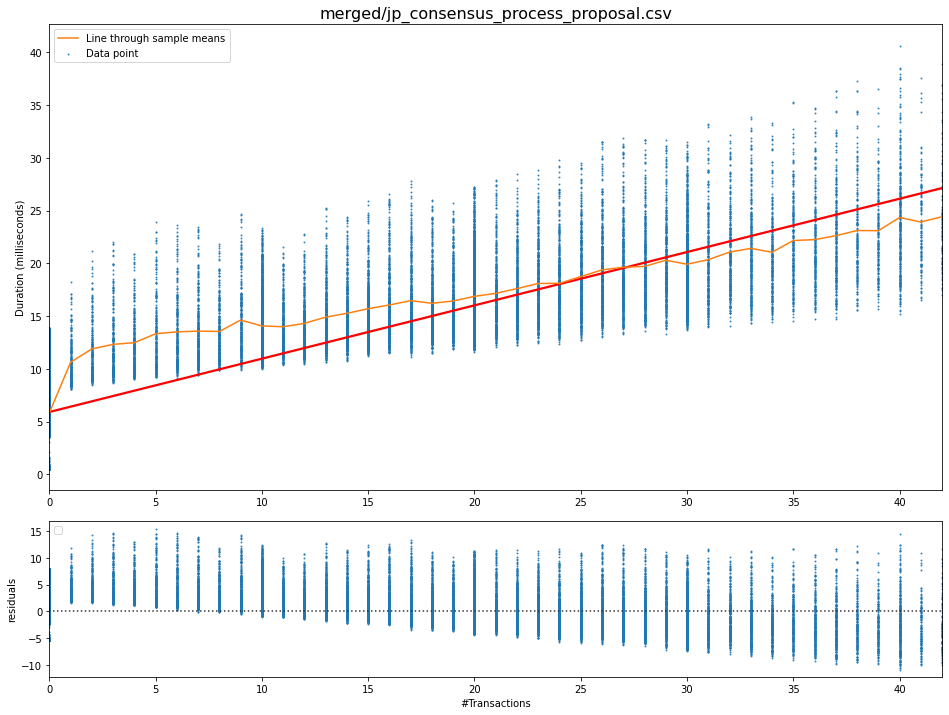

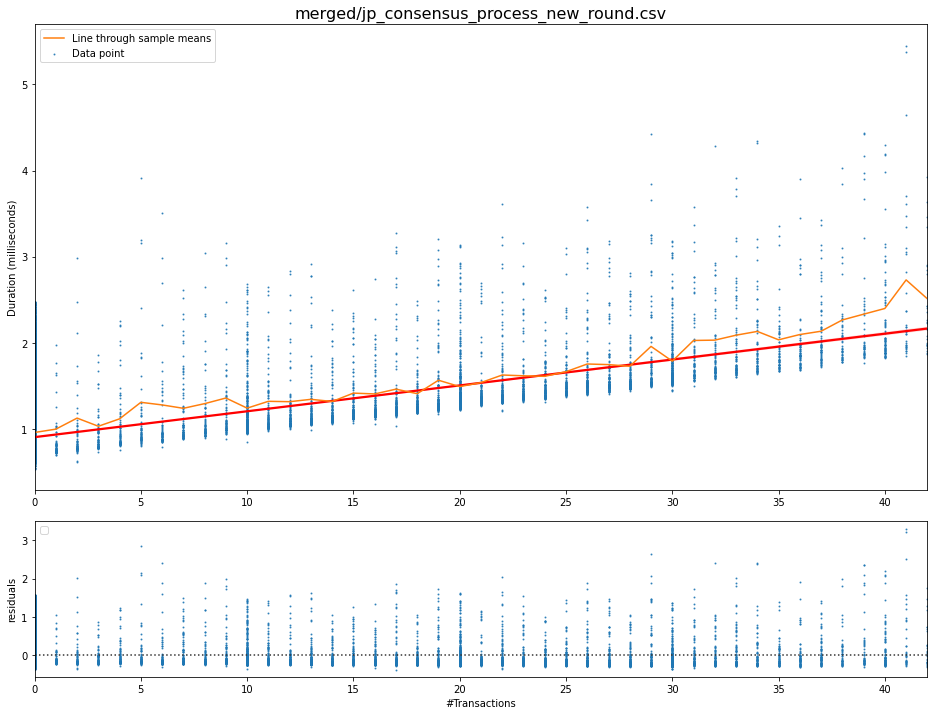

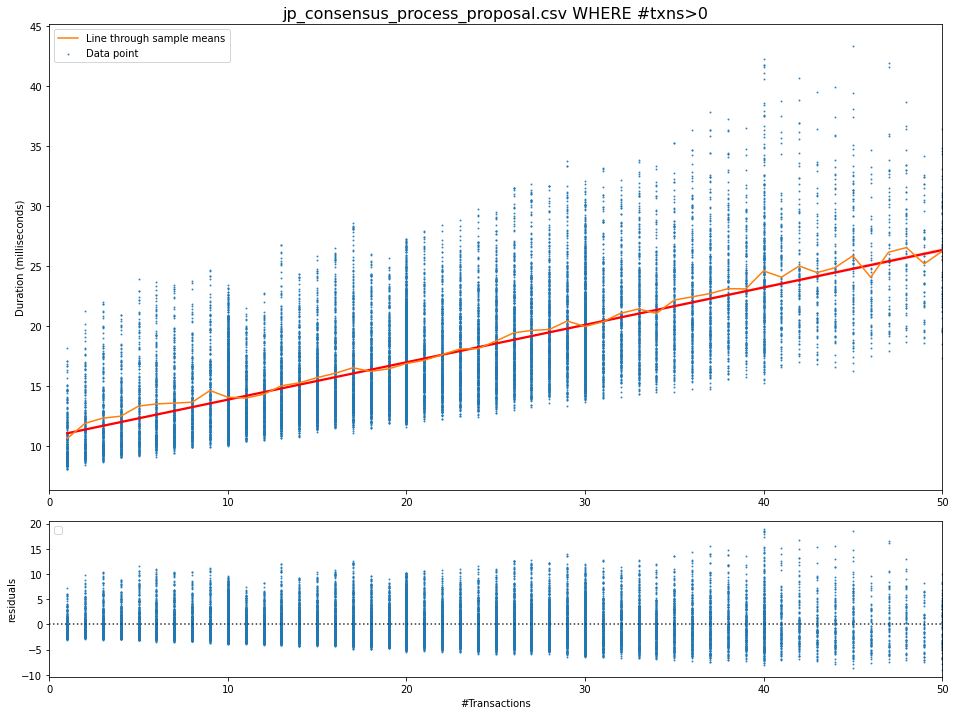

In [7]:
#Linear regression plot with Seaborn, showing a 95% confidence interval
i = 0
while i < len(res_array):
    fig, ax = plt.subplots(nrows=2, figsize=(16,12), gridspec_kw={'height_ratios':[3,1], 'hspace':0.1})

    sns.regplot(x='txns', y='duration', data=res_array[i], ax=ax[0], ci=95, label='Data point', line_kws={"color": "red"}, scatter_kws={'s':1})
    sns.residplot(x='txns', y='duration', data=res_array[i], ax=ax[1], scatter_kws={'s':1})
    ax[0].plot(mean_array[i]["txns"], mean_array[i]["duration"], label="Line through sample means")

    ax[0].set_title(files[i], fontsize=16)
    ax[0].set_xlabel("")
    ax[0].set_ylabel("Duration (milliseconds)")
    ax[0].set_xlim(left=0, right=res_array[i]['txns'].max())
    ax[0].legend(loc='upper left')

    ax[1].set_xlabel("#Transactions")
    ax[1].set_ylabel("residuals")
    ax[1].set_xlim(left=0, right=ax[0].get_xlim()[1])
    ax[1].legend(loc='upper left')
    i += 1

In [8]:
def create_four_dist_plots(title, data):
    fig, ax = plt.subplots(2, 2, figsize=(16,8))
    plt.subplots_adjust(hspace=0.5)
    sns.distplot(data, ax=ax[0][0], bins=50)
    sns.boxplot(data, ax=ax[0][1], fliersize=1, linewidth=1)
    sns.boxenplot(data, ax=ax[1][0])
    sns.violinplot(data, ax=ax[1][1], inner='quartile')

    fig.suptitle(title, fontsize=16)
    ax[0,0].set_title("Distribution")
    ax[0,1].set_title("Boxplot")
    ax[1,0].set_title("Boxenplot")
    ax[1,1].set_title("Violinplot")

    ax[0,0].set_xlabel("Duration (milliseconds)")
    ax[0,1].set_xlabel("Duration (milliseconds)")
    ax[1,0].set_xlabel("Duration (milliseconds)")
    ax[1,1].set_xlabel("Duration (milliseconds)")

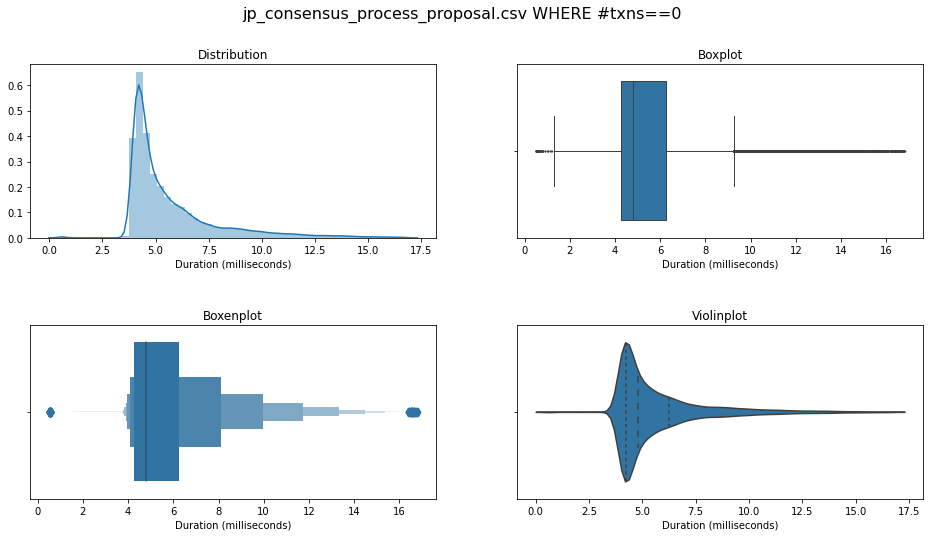

In [9]:
create_four_dist_plots("jp_consensus_process_proposal.csv WHERE #txns==0", left['duration'])

In [10]:
def get_counts_per_timewindow(X, nr_bins):
    X_res = []
    Y_res = []

    end_time = max(X)
    part = end_time/nr_bins
    for x in range(nr_bins):
        position = (part * x) + (0.5 * part)
        X_res.append(position)

        y_part = X[(X >= (part * x)) & (X < (part * (x+1)))]
        Y_res.append(len(y_part)/part)
    return X_res, Y_res

Average Throughput: 330.8856117180402


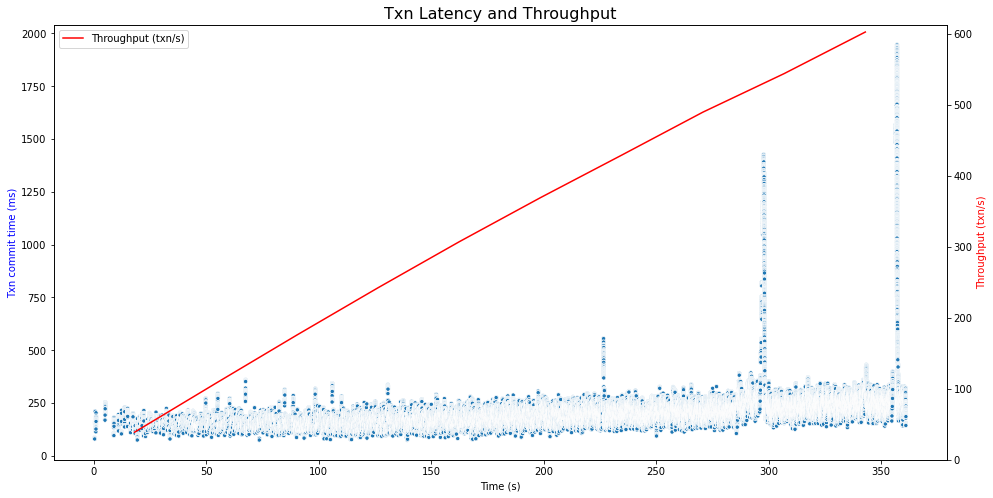

In [11]:
#Load in both client txns start time and end times
ac_dataframe = pd.read_csv(base_directory + "merged/jp_ac_client_transaction.csv", names=["address", "sequence_number", "timestamp"])
f = open(base_directory + "container0/jp_blockstore_process_block.csv")
lines = f.read().split("\n")
f.close()

dictionary = {"address":[], "sequence_number":[], "timestamp":[]}

#Parse blockstore into a dataframe
for x in range(len(lines)):
    line = lines[x].replace('"', '')
    parts = line.split(",")

    timestamp = parts[0]
    for y in range(1, len(parts)):
        acc_seq = parts[y].split(":")
        dictionary["address"].append(acc_seq[0])
        dictionary["sequence_number"].append(acc_seq[1])
        dictionary["timestamp"].append(timestamp)

blockstore_dataframe = pd.DataFrame(dictionary)
blockstore_dataframe[['sequence_number', 'timestamp']] = blockstore_dataframe[['sequence_number', 'timestamp']].apply(pd.to_numeric)

#left join to add commit times
result = pd.merge(ac_dataframe, blockstore_dataframe, how='left', on=['address', 'sequence_number'], suffixes=['_submit', '_commit'])

#calculate the txn_latency and relative_txn_start_time, then add it to the result dataframe
txn_latency = result['timestamp_commit'] - result['timestamp_submit']
txn_rel_start_time = (result['timestamp_commit'] - result['timestamp_submit'].min())/1000
result['txn_latency(ms)'] = txn_latency
result['txn_rel_commit_time'] = txn_rel_start_time

result.sort_values(by=['timestamp_submit'], inplace=True, ignore_index=True)

avg_throughput = len(result) / max(result['txn_rel_commit_time'])
print("Average Throughput: " + str(avg_throughput))

#Create a scatterplot with 2 Y-axis, txn_latency and txn_througput
fig, ax1 = plt.subplots(figsize=(16,8))
ax2 = ax1.twinx()
sns.scatterplot(x=result['txn_rel_commit_time'], y=result['txn_latency(ms)'], label='Data point', size=1, ax=ax1)

X, Y = get_counts_per_timewindow(result['txn_rel_commit_time'], int(max(X)/5))
ax2.plot(X, Y, color='red', label='Throughput (txn/s)')
ax2.set_ylim(bottom=0, top=max(Y)+10)

ax1.set_title("Txn Latency and Throughput", fontsize=16)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Txn commit time (ms)', color='blue')
ax2.set_ylabel('Throughput (txn/s)', color='red')
ax1.get_legend().remove()
ax2.legend();

,txn_latency(ms)
count,119455.000000
mean,221.007802
std,137.429706
min,75.000000
25%,171.000000
50%,204.000000
75%,239.000000
max,1947.000000


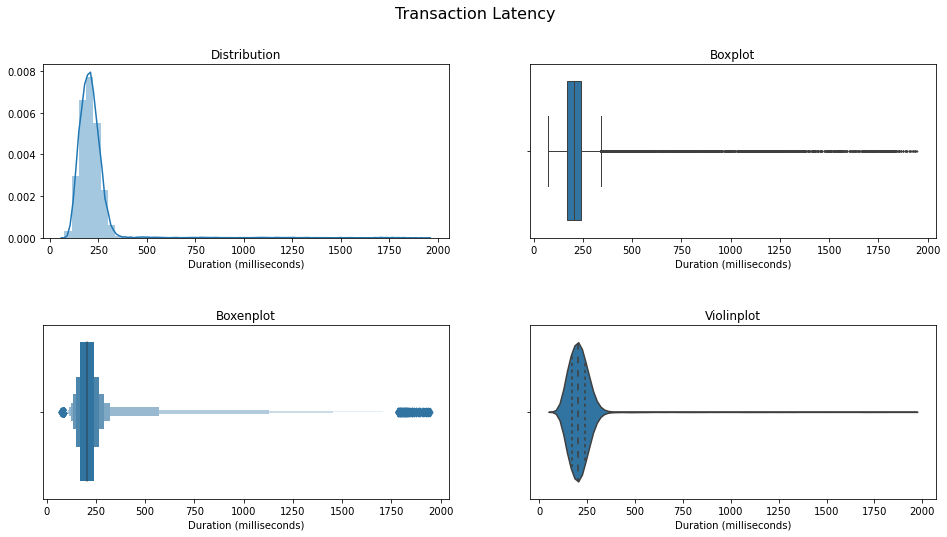

In [12]:
#Visualize txn_latency in distributions
create_four_dist_plots("Transaction Latency", result['txn_latency(ms)'])
result[['txn_latency(ms)']].describe()

In [13]:
#Put data points into 25 evenly divided bins and return the 15 largest bins
bins = left['duration'].value_counts(bins=25, sort=False).nlargest(15)
left = left[pd.cut(left['duration'], bins.index).notnull()]

left['shift'] = left['duration'] - min(left['duration'])

1.0801082454325512 -9.574469804668066e-06 1.6755169222344124
KstestResult(statistic=0.08049695313263361, pvalue=0.0)
KstestResult(statistic=0.07521606902010614, pvalue=9.391033205601496e-282)


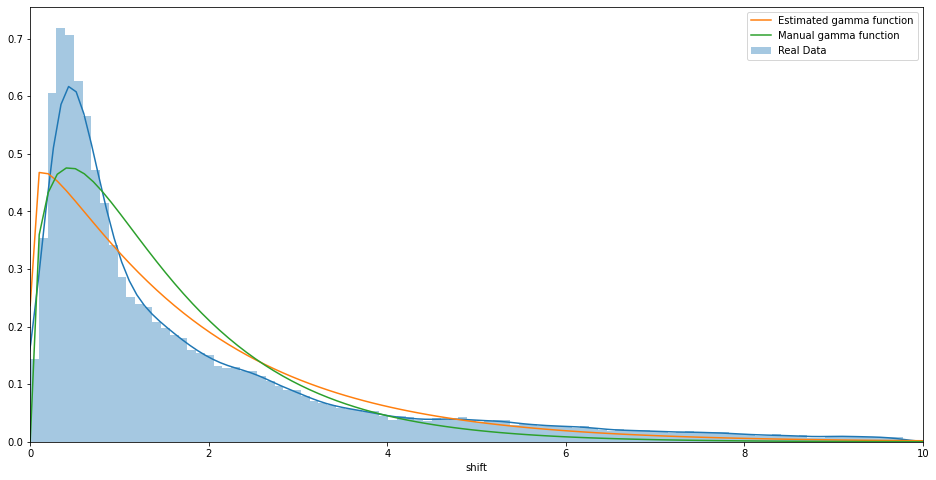

In [14]:
fig, ax = plt.subplots(figsize=(16,8))
sns.distplot(left['shift'], ax=ax, label="Real Data", bins=100)

#Fitting the gamma distribution
X = np.linspace(0, 10, 100)
fit_alpha, fit_loc, fit_scale = stats.gamma.fit(left['shift'])
gamma_fit = stats.gamma(a=fit_alpha, loc=fit_loc, scale=fit_scale)
gamma_manual = stats.gamma(a=1.4, loc=0, scale=1.1)
ax.plot(X, gamma_fit.pdf(X), label="Estimated gamma function")
ax.plot(X, gamma_manual.pdf(X), label="Manual gamma function")
ax.set_xlim(0,10)
ax.legend()
print(fit_alpha, fit_loc, fit_scale)

p_fit = stats.kstest(left['shift'], gamma_fit.cdf)
p_manual = stats.kstest(left['shift'], gamma_manual.cdf)
print(p_fit)
print(p_manual)

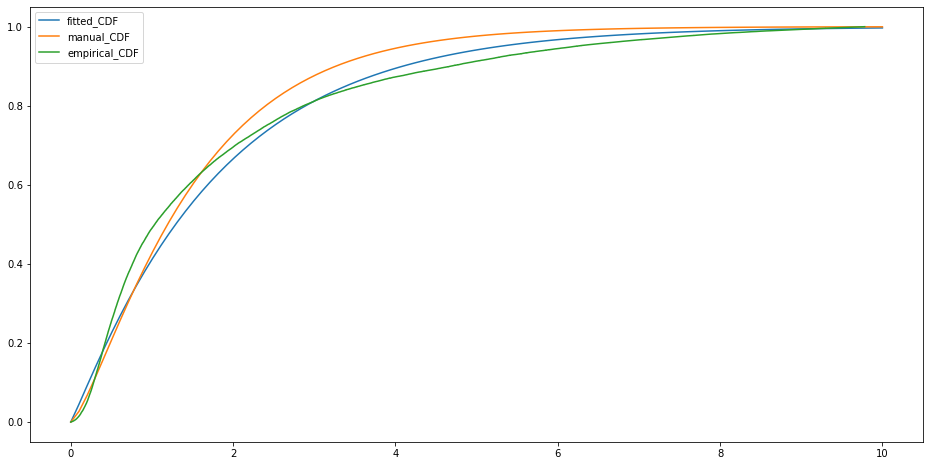

In [15]:
fig, ax = plt.subplots(figsize=(16,8))
ecdf = ECDF(left['shift'])

ax.plot(X, gamma_fit.cdf(X), label='fitted_CDF')
ax.plot(X, gamma_manual.cdf(X), label='manual_CDF')
ax.plot(ecdf.x, ecdf.y, label='empirical_CDF')
ax.legend()

76.39803039850773 -12.063573487990709 0.5010259668533339
#entries: 72
KstestResult(statistic=0.09052327721996561, pvalue=0.5656650658694968)


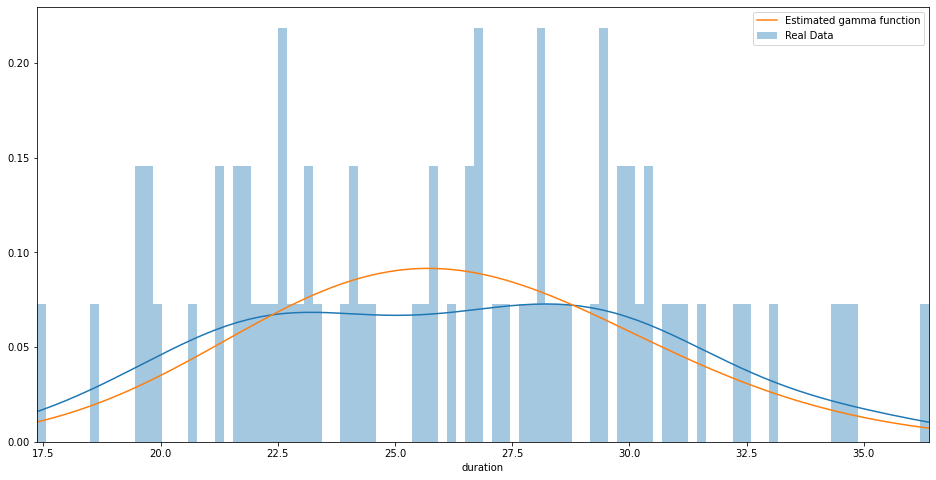

In [71]:
result = res_array[3][res_array[3]['txns'] == 50]

fig, ax = plt.subplots(figsize=(16,8))
sns.distplot(result['duration'], ax=ax, label="Real Data", bins=100)

#Fitting the gamma distribution
X = np.linspace(result['duration'].min(), result['duration'].max(), 100)
fit_alpha, fit_loc, fit_scale = stats.gamma.fit(result['duration'])
gamma_fit = stats.gamma(a=fit_alpha, loc=fit_loc, scale=fit_scale)
ax.plot(X, gamma_fit.pdf(X), label="Estimated gamma function")
ax.set_xlim(X.min(), X.max())
ax.legend()
print(fit_alpha, fit_loc, fit_scale)

p_fit = stats.kstest(result['duration'], gamma_fit.cdf)
print("#entries:", result['txns'].count())
print(p_fit)

[0.0, 1.3144020972043058e-237, 8.415301702997e-31, 3.1074810037628425e-33, 2.1384133621545636e-35, 6.2614231173597e-39, 4.0457750758114e-33, 2.8758459876493867e-30, 9.300649428354607e-36]
DescribeResult(nobs=9, minmax=(0.0, 2.8758459876493867e-30), mean=4.138400116747926e-31, variance=9.296646500143401e-61, skewness=2.146044021591347, kurtosis=3.016667249064577)

[0.0, 0.0, 0.0, 3.0087488992311223e-279, 1.74483310600107e-190, 2.9071568100621424e-120, 4.371268196198159e-55, 4.5610292344044774e-20, 2.1039647448886635e-44]
DescribeResult(nobs=9, minmax=(0.0, 4.5610292344044774e-20), mean=5.067810260449419e-21, variance=2.3114430752324765e-40, skewness=2.4748737341529163, kurtosis=4.125000000000001)

[0.010448475930269728, 1.2681146020236402e-09, 1.5448604702236022e-11, 0.03965067931965508, 0.008708974032123784, 1.5091202095878074e-06, 0.15595042561203534, 0.034007437653878245, 0.02696957356763596, 6.683350884506339e-21, 0.0006625603634283929, 0.02100793632395891, 1.6196197829572902e-19, 0

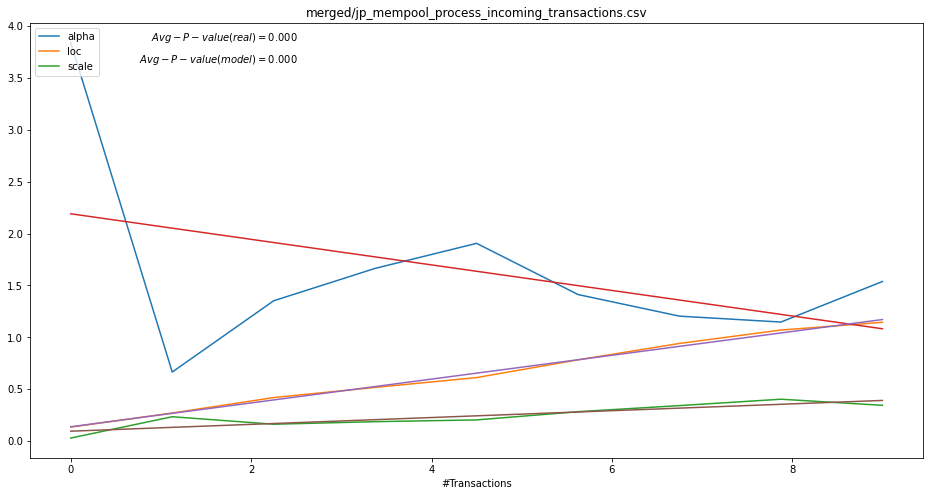

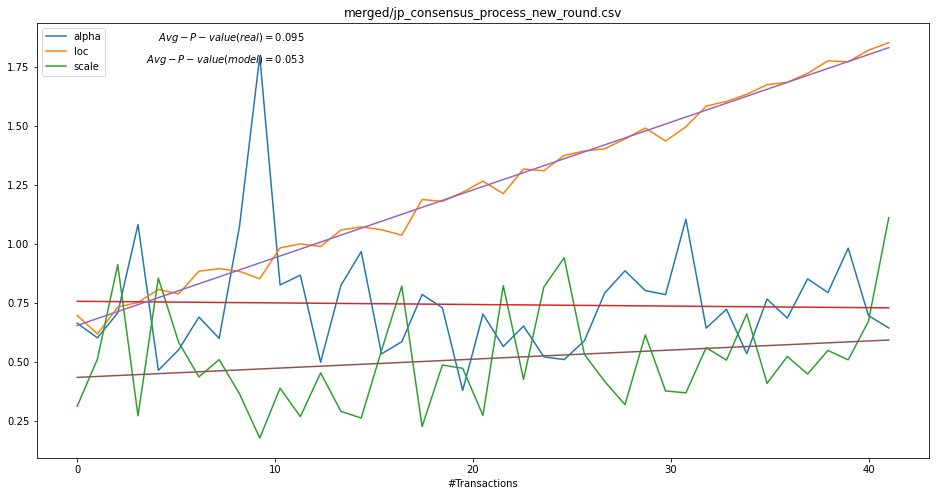

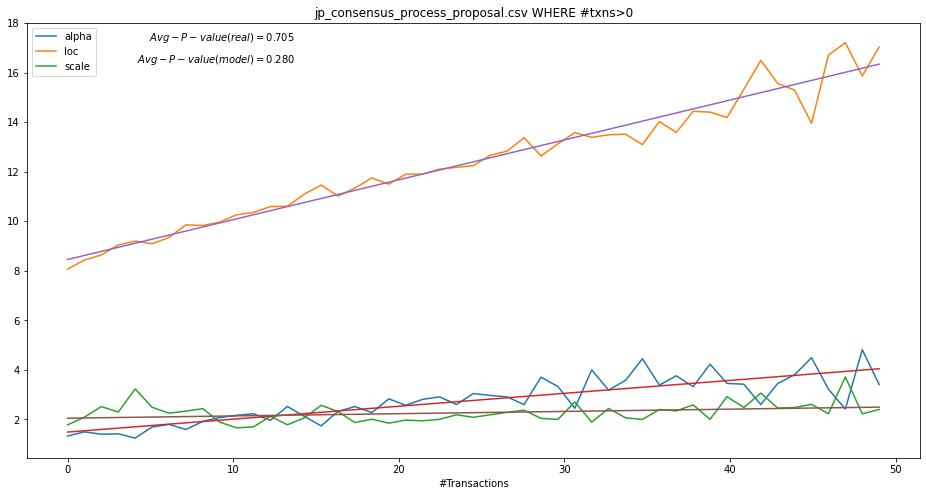

In [69]:
p_values_list_real = []
p_values_list_model = []

fit_alpha_list = []
fit_loc_list = []
fit_scale_list = []

model_nr = 0
while model_nr < len(res_array):
    #res_array[1] contains #txns==0
    if model_nr == 1:
        model_nr += 1
        p_values_list_real.append([])
        p_values_list_model.append([])
        continue
    
    #Fit and print the Gamma distribution parameters
    temp_fit_alpha = []
    temp_fit_loc = []
    temp_fit_scale = []
    temp_p_fit_real = []
    
    i = 1
    max_txns = max(res_array[model_nr]['txns']) - 1
    while i <= max_txns:
        data = res_array[model_nr][res_array[model_nr]['txns'] == i]['duration']
        fit_alpha, fit_loc, fit_scale = stats.gamma.fit(data)
        temp_fit_alpha.append(fit_alpha)
        temp_fit_loc.append(fit_loc)
        temp_fit_scale.append(fit_scale)

        p_fit = stats.kstest(data, stats.gamma(a=fit_alpha, loc=fit_loc, scale=fit_scale).cdf)
        temp_p_fit_real.append(p_fit[1])
        i += 1

    fit_alpha_list.append(temp_fit_alpha)
    fit_loc_list.append(temp_fit_loc)
    fit_scale_list.append(temp_fit_scale)
    p_values_list_real.append(temp_p_fit_real)
    
    fig, ax = plt.subplots(figsize=(16,8))
    ax.set_title(files[model_nr])
    ax.set_xlabel('#Transactions')

    X = np.linspace(0, max_txns, len(temp_fit_alpha)).reshape(-1,1)
    ax.plot(X, temp_fit_alpha, label='alpha')
    ax.plot(X, temp_fit_loc, label='loc')
    ax.plot(X, temp_fit_scale, label='scale')
    ax.legend(loc='upper left')

    #Model the three gamma parameters into a linear fit
    linear_regressor_alpha = LinearRegression()
    linear_regressor_alpha.fit(X, temp_fit_alpha)
    Y_alpha_predictor = linear_regressor_alpha.predict(X)
    ax.plot(X, Y_alpha_predictor)

    linear_regressor_loc = LinearRegression()
    linear_regressor_loc.fit(X, temp_fit_loc)
    Y_loc_predictor = linear_regressor_loc.predict(X)
    ax.plot(X, Y_loc_predictor)

    linear_regressor_scale = LinearRegression()
    linear_regressor_scale.fit(X, temp_fit_scale)
    Y_scale_predictor = linear_regressor_scale.predict(X)
    ax.plot(X, Y_scale_predictor)

    #Calculate the p-values for the linear fit models
    temp_p_fit_model = []
    i = 1
    while i <= max_txns:
        data = res_array[model_nr][res_array[model_nr]['txns'] == i]['duration']

        a_pred = linear_regressor_alpha.predict([[i]])
        loc_pred = linear_regressor_loc.predict([[i]])
        scale_pred = linear_regressor_scale.predict([[i]])

        p_fit = stats.kstest(data, stats.gamma(a=a_pred, loc=loc_pred, scale=scale_pred).cdf)
        temp_p_fit_model.append(p_fit[1])
        i += 1
        
    p_values_list_model.append(temp_p_fit_model)
    ax.text(0.3, 0.95, "$Avg-P-value(real)={:.3f}$".format(stats.describe(p_values_list_real[model_nr])[2]), verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)
    ax.text(0.3, 0.9, "$Avg-P-value(model)={:.3f}$".format(stats.describe(p_values_list_model[model_nr])[2]), verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)

    model_nr += 1

i = 0
while i < len(p_values_list_real):
    if i == 1:
        i += 1
        continue
        
    print(p_values_list_real[i])
    print(stats.describe(p_values_list_real[i]))
    print()
    print(p_values_list_model[i])
    print(stats.describe(p_values_list_model[i]))
    print();
    i += 1

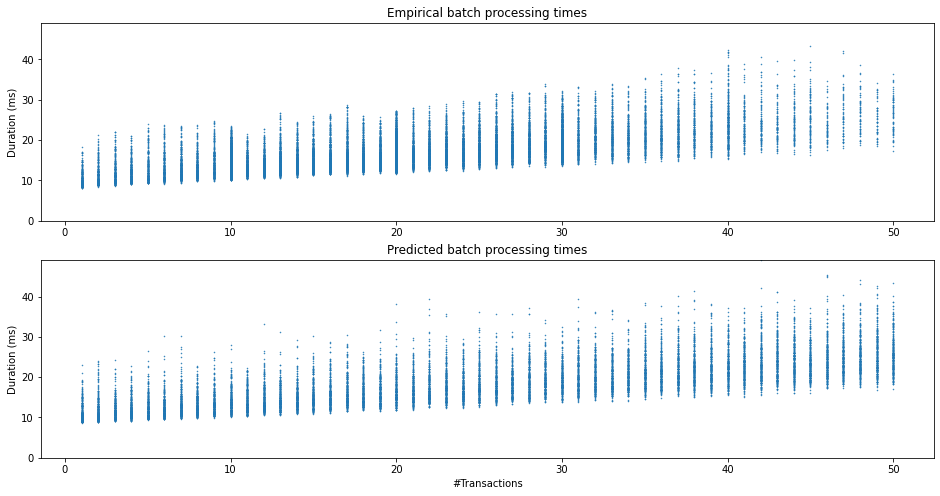

In [19]:
#Create and plot both the empirical/estimated batch processing times
X_data = []
Y_data = []

i = 1
while i <= 50:
    nr_txns = [[i]]
    a_pred = linear_regressor_alpha.predict(nr_txns)
    loc_pred = linear_regressor_loc.predict(nr_txns)
    scale_pred = linear_regressor_scale.predict(nr_txns)

    rvs = stats.gamma.rvs(a=a_pred, loc=loc_pred, scale=scale_pred, size=300)
    X_data.extend([i] * len(rvs))
    Y_data.extend(rvs)
    i += 1
  
fig, ax = plt.subplots(2, 1, figsize=(16,8))
ax[0].set_title("Empirical batch processing times")
ax[0].set_ylabel('Duration (ms)')
ax[0].scatter(res_array[3]['txns'], res_array[3]['duration'], marker='.', s=1, label='Data point');

ax[1].set_title("Predicted batch processing times")
ax[1].set_xlabel('#Transactions')
ax[1].set_ylabel('Duration (ms)')
ax[1].scatter(X_data, Y_data, marker='.', s=1, label='Data point');

max_y = max(max(res_array[3]['duration']), max(Y_data))
ax[0].set_ylim(0, max_y)
ax[1].set_ylim(0, max_y);

In [20]:
p_values_list_real = []
p_values_list_model = []

fit_alpha_list = []
fit_loc_list = []
fit_scale_list = []

#Fit and print the Gamma distribution parameters
i = 1
while i < 41:
    data = res_array[2][res_array[2]['txns'] == i]['duration']
    fit_alpha, fit_loc, fit_scale = stats.gamma.fit(data)
    fit_alpha_list.append(fit_alpha)
    fit_loc_list.append(fit_loc)
    fit_scale_list.append(fit_scale)
    
    p_fit = stats.kstest(data, stats.gamma(a=fit_alpha, loc=fit_loc, scale=fit_scale).cdf)
    p_values_list_real.append(p_fit[1])
    i += 1

pprint(p_values_list_real)
stats.describe(p_values_list_real)

[0.010448475930269728,
 1.2681146020236402e-09,
 1.5448604702236022e-11,
 0.03965067931965508,
 0.008708974032123784,
 1.5091202095878074e-06,
 0.15595042561203534,
 0.034007437653878245,
 0.02696957356763596,
 6.683350884506339e-21,
 0.0006625603634283929,
 0.02100793632395891,
 1.6196197829572902e-19,
 0.0001589272891170351,
 0.000474854002696507,
 2.061895907256624e-16,
 2.563171142236198e-13,
 0.002388681608444053,
 5.725408572830036e-07,
 1.5637491854492517e-76,
 0.001132689169527186,
 2.3254339173022766e-10,
 0.00033871288761904556,
 5.579045987997667e-06,
 8.840997912705859e-10,
 0.00036736530870610276,
 2.0476601175617773e-05,
 1.3763426939829481e-05,
 2.962692013100952e-08,
 3.601300137295304e-23,
 0.11694363457755517,
 0.143705868126344,
 0.29507517715737347,
 0.0575404482946522,
 0.8456800199201353,
 0.0779198922914118,
 0.794159634359458,
 0.40297569883093454,
 0.06672541042775859,
 0.08245028359331527]


DescribeResult(nobs=40, minmax=(1.5637491854492517e-76, 0.8456800199201353), mean=0.07963713233526468, variance=0.03653874021042595, skewness=3.1460028121664956, kurtosis=9.19585173126128)